In [1]:
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy, torch2np
import os
# from importlib import reload

In [2]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [3]:
# Read the meshgrid for computing the energy

vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)
cut = 13 # removes the influence of inflow/outflow
dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
DX, DY = np.meshgrid(dx,dy)
DX = strip_cross(DX[...,None,None], cut).squeeze()
DY = strip_cross(DY[...,None,None], cut).squeeze()

In [89]:

## Data reading
parameters = [
        (0.01,2.5,0.11111),
        (0.01,3.5,0.11111),
        (0.01,4.0,0.22222),
        (0.01,5.0,0.33333),
        (0.01,7.0,0.11111),
        (0.01,7.5,0.33333),
]
# Parameters:
# Re = 1
# Wi = 7.5
# beta = 0.6
ind = 5
Re ,Wi ,beta = parameters[ind]
alpha = (1-beta)/(Re*Wi)

# type of simulation
case = 'cross'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
print('Data shape: ',X.shape)

Nt = X.shape[1] # number of snapshots
q = X.reshape((181,181,5,-1))




X_data = strip_cross(q, cut)
X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

# convert data
X_torch = torch.from_numpy(X_data)
X = torch2np(X_torch)
param = torch.ones((X_torch.shape[0], 2))
param[:] = torch.Tensor(parameters[ind][1:] )
#normalize data inside autoencoder


Data shape:  (163805, 999)


In [42]:
# NN part
minmax = torch.load('../npz_data/min_max_cross_dataset.pt')
upper_bound = minmax['max']
lower_bound = minmax['min']
latent_dim = 3
autoencoder = Autoencoder.ParametricVAEModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

autoencoder.load_state_dict(torch.load(f'../Models/VAE_CrossParametric_Latent_{latent_dim}/best_autoencoder',map_location=torch.device('cpu')))


<All keys matched successfully>

In [90]:
# Run test
with torch.no_grad():
    X_ae_torch,_,_ = autoencoder(X_torch.float(), param.float())
X_ae = torch2np(X_ae_torch)

In [91]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])

# # Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

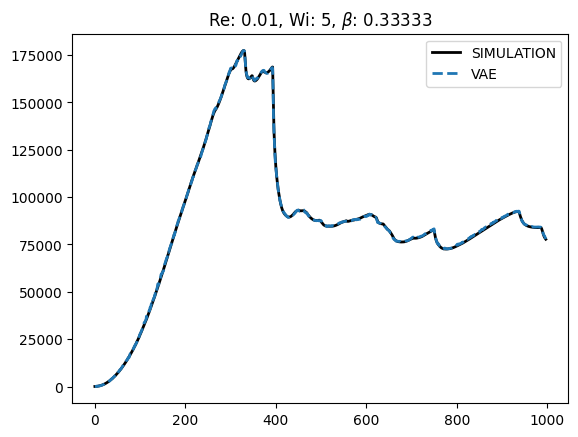

In [74]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

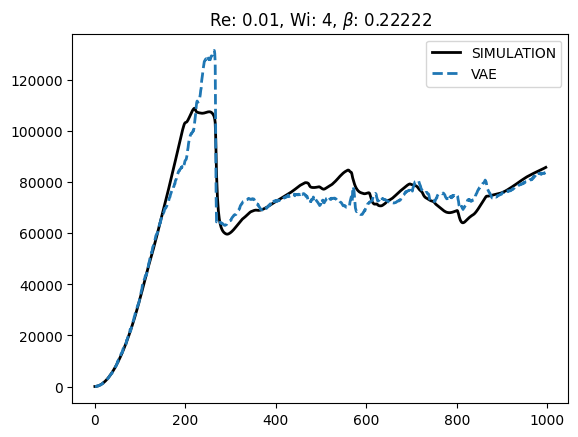

In [81]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

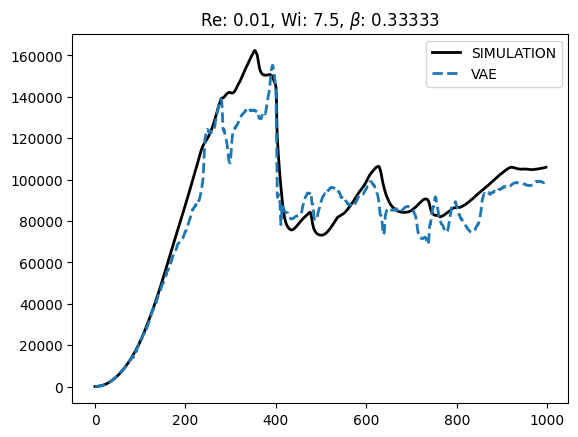

In [92]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

In [93]:
## Visual Plots
X_rec = reconstruct_cross(X_ae.reshape((-1,5,999)), cut)
X_rec[:65-cut,:65-cut] = np.NaN
X_rec[-65+cut:,:65-cut] = np.NaN
X_rec[:65-cut,-65+cut:] = np.NaN
X_rec[-65+cut:,-65+cut:] = np.NaN

X_true = reconstruct_cross(X.reshape((-1,5,999)), cut)
X_true[:65-cut,:65-cut] = np.NaN
X_true[-65+cut:,:65-cut] = np.NaN
X_true[:65-cut,-65+cut:] = np.NaN
X_true[-65+cut:,-65+cut:] = np.NaN

tra_Ar = X_rec[...,2,:]**2 + X_rec[...,4,:]**2 + 2* X_rec[...,3,:]**2
tra_At = X_true[...,2,:]**2 + X_true[...,4,:]**2 + 2* X_true[...,3,:]**2

Text(0.5, 0.98, 'Re: 0.01, Wi: 7.5, $\\beta$: 0.33333')

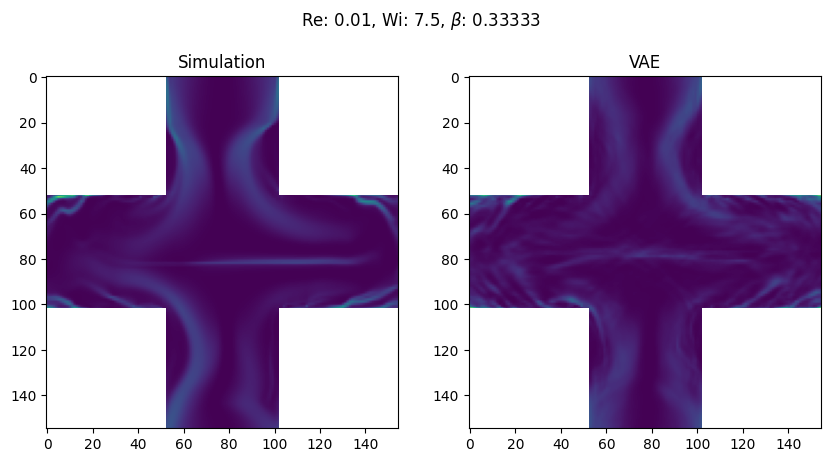

In [94]:
f, ax = plt.subplots(1,2, figsize = (10,5))
t = 700

ax[0].imshow(tra_At[...,t])
ax[0].set_title('Simulation')
ax[1].imshow(tra_Ar[...,t])
ax[1].set_title('VAE')
f.suptitle(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')